# Libs

In [1]:
from ibm_botocore.client import Config
import ibm_boto3

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200209112829-0001
KERNEL_ID = ae790a45-8e56-41eb-9ce9-498c25db1987


In [11]:
SEED = 42

# Numpy
import numpy as np
np.random.seed(SEED)
from numpy import loadtxt

# Pandas
import pandas as pd

# Sklearn

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.model_selection import cross_val_score

# Metrics and tuning
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

# PySpark
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import lit
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Stats
from scipy import stats

# Vizualization
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Data

In [38]:
credentials = {
    'IAM_SERVICE_ID': '',
    'IBM_API_KEY_ID': '',
    'ENDPOINT': '',
    'IBM_AUTH_ENDPOINT': '',
    'BUCKET': '',
}

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

cos.download_file(Bucket=credentials['BUCKET'], Key='train', Filename='train.csv')
cos.download_file(Bucket=credentials['BUCKET'], Key='test', Filename='test.csv')
cos.download_file(Bucket=credentials['BUCKET'], Key='y_train', Filename='y_train.csv')
cos.download_file(Bucket=credentials['BUCKET'], Key='y_test', Filename='y_test.csv')

from numpy import loadtxt

train_data = loadtxt('train.csv', delimiter=',')
test_data = loadtxt('test.csv', delimiter=',')
y_train = loadtxt('y_train.csv', delimiter=',')
y_test = loadtxt('y_test.csv', delimiter=',')

# Prepare Spark DataFrame

In [39]:
rdd1 = sc.parallelize(train_data)
rdd2 = rdd1.map(lambda x: [float(i) for i in x])
train_df = rdd2.toDF()

vectorAssembler = VectorAssembler(inputCols=[f'_{i}' for i in range(1, train_data.shape[1]+1)], outputCol="features")
train_df = vectorAssembler.transform(train_df)

train_df = train_df.withColumn("id", monotonically_increasing_id())

b = [int(i) for i in list(y_train)]

train_labels = spark.createDataFrame(b, IntegerType())
train_labels = train_labels.withColumn("id", monotonically_increasing_id())
train_labels = train_labels.selectExpr("id as id", "value as label")

train = train_df.join(train_labels, "id")

In [40]:
rdd1 = sc.parallelize(test_data)
rdd2 = rdd1.map(lambda x: [float(i) for i in x])
test_df = rdd2.toDF()

vectorAssembler = VectorAssembler(inputCols=[f'_{i}' for i in range(1, test_data.shape[1]+1)], outputCol="features")
test_df = vectorAssembler.transform(test_df)

test_df = test_df.withColumn("id", monotonically_increasing_id())

b = [int(i) for i in list(y_test)]

test_labels = spark.createDataFrame(b, IntegerType())
test_labels = test_labels.withColumn("id", monotonically_increasing_id())
test_labels = test_labels.selectExpr("id as id", "value as label")

test = test_df.join(test_labels, "id")

# Choose, justify and apply a model performance indicator

We will use area under the ROC curve. AUROC of a test can be used as a criterion to measure the test's discriminative ability, i.e. how good is the test in a given clinical situation. It tells how much model is capable of distinguishing between classes. 

We dont want to predict 'Death in 5 year' status with error for the patient. We can afford to make a mistake and telling the patient, that he will be alive, but we dont want to make false predictions about the death status. So we want to change treshold to minimize false negative mistakes - when the status should be living, but we predict "Death".

We want to maximize recall (Type II error minimization) param and maximize AUROC.

# Implement your algorithm

## Non-deep learning algorithm

## Logistic Regression

In [6]:
def plot_scores(optimizer):
    param_C = np.array(optimizer.cv_results_['param_C'])
    mean_cv = optimizer.cv_results_['mean_test_score']
    std_cv = optimizer.cv_results_['std_test_score']
    
    temp_1 = mean_cv - std_cv
    temp_2 = mean_cv + std_cv                                             
    
    plt.semilogx(param_C, mean_cv)
    plt.fill_between(np.array(param_C, dtype=float), np.array(temp_1, dtype=float), np.array(temp_2, dtype=float), alpha=0.3)
    plt.show()

In [7]:
param_grid = {'C': [0.001, 0.001, 0.1, 0.5, 1, 5, 10]}
cv = 5

estimator = LR(solver='liblinear')

optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv, scoring='recall')
optimizer_zeros.fit(train_data, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.001, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

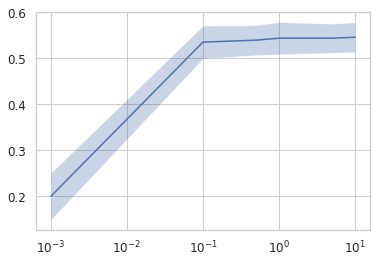

In [8]:
plot_scores(optimizer_zeros)

In [9]:
optimizer_zeros.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
roc_auc_score_zeros = roc_auc_score(y_test, optimizer_zeros.best_estimator_.predict_proba(test_data)[:, 1])

In [13]:
roc_auc_score_zeros

0.6894016644189337

In [14]:
optimizer_zeros.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Logistic Regression - Spark

In [15]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100, regParam=0.1, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (49,[0,1,2],[-0.29470054869103085,-0.06101756192031752,-0.05263230887826709])
Intercept: -0.4127639032530756


In [16]:
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold

maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lrModel._java_obj.setThreshold(bestThreshold)

objectiveHistory:
0.6732188733949639
0.670962758941399
0.6620747268211165
0.661034623960776
0.6607940494940365
0.660792033392905
0.6607885282462737
0.6607882254674488
0.6607881985236744
0.6607881794632285
0.6607881490729325
0.6607880988911647
0.6607880987850395
0.6607880984355837
0.6607880983714052
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.001424501424501...|0.008528784648187633|
|0.002849002849002849|0.019189765458422176|
|0.002849002849002849|0.031982942430703626|
|0.007122507122507123| 0.03837953091684435|
|0.008547008547008548| 0.04904051172707889|
|0.011396011396011397|0.057569296375266525|
|0.014245014245014245| 0.06396588486140725|
|0.018518518518518517| 0.07036247334754797|
|0.022792022792022793|  0.0767590618336887|
| 0.02564102564102564| 0.08528784648187633|
| 0.02564102564102564| 0.09808102345415778|
|0.029914529914529916|  0.10447761194029

JavaObject id=o308

In [17]:
predictions = lrModel.transform(test)

In [18]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")

predict_test = lrModel.transform(test)
predict_train = lrModel.transform(train)

predict_test.select("label","rawPrediction","prediction","probability").show(5)

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    1|[0.46680720585930...|       0.0|[0.61462778698305...|
|    0|[-0.0820794502592...|       1.0|[0.47949164993391...|
|    1|[0.04157605575882...|       0.0|[0.51039251696811...|
|    0|[0.54043135554880...|       0.0|[0.63191275632390...|
|    0|[0.29743659938446...|       0.0|[0.57381575296537...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.725007441425352
The area under ROC for test set is 0.6858162560442098


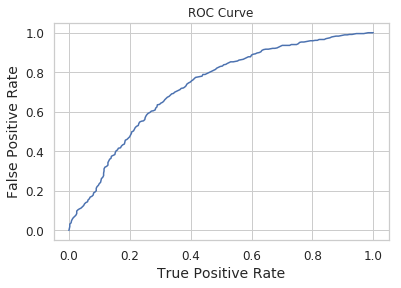

Training set areaUnderROC: 0.7250241466659378


In [19]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

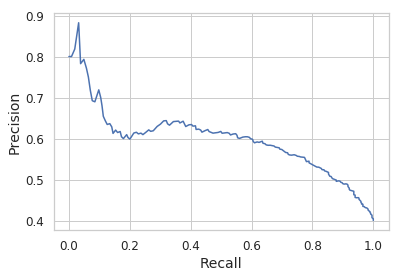

In [20]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Deep Learning Algorithm

In [21]:
# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [49, 30, 10, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)

In [22]:
predictionAndLabels = result.select("prediction", "label")

predict_test = lrModel.transform(test)
predict_train = lrModel.transform(train)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

test_accuracy = evaluator.evaluate(predict_test)
train_accuracy = evaluator.evaluate(predict_train)

print("Test Acc = %g" % (test_accuracy))
print("Train Acc = %g" % (train_accuracy))

Test Acc = 0.606362
Train Acc = 0.622545


## Sequential NN

In [23]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(49, input_dim=49, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)

kfold = StratifiedKFold(n_splits=10, shuffle=True)

results = cross_val_score(estimator, train_data, y_train, cv=kfold)

print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Baseline: 64.66% (3.16%)


# Result

As we can see, Deep learning algorithms perform worse than classic Logistic Regression on this dataset. 

So, I decided to proceed with Logistic Regression.

P.S. Actually, I tried a LOT of other algorithms in my draft notebook: Random Forest, GB, Bayes, SVM, KNN e.t.c. 
Link: https://github.com/OzmundSedler/IBM-advanced-DS-coursera/blob/master/4%20Capstone%20/ML-project-draft.ipynb

# Apply at least one additional iteration in the process model involving at least the feature creation task
Record impact on model performance

**Area under ROC for train/test set**

1. **0.705/0.663** ------ **Initial model** (Without normalization), not exists in the notebooks, was declared in the draft - 
2. **0.725/0.686** ------ **Normalization** of num data was done in the previous notebook - 
3. **0.724/0.686** ------ **Feature selection** (moved from 49 features to 40)
4. **0.775/0.692** ------ **Gridsearch** for the best LR params 
5. **0.754/0.740** ------ **Feature Imputation** 

## Iteration 1 - feature selection with ChiSqSelector

In [24]:
number_of_top_features = [20, 30, 40, 45]

for number in number_of_top_features:
    selector = ChiSqSelector(featuresCol='features', outputCol=f'SelectedFeatures_{number}', labelCol='label', numTopFeatures=number)
    
    train_selected = selector.fit(train).transform(train)
    test_selected = selector.fit(test).transform(test)
    
    lr = LogisticRegression(featuresCol=f'SelectedFeatures_{number}', labelCol='label', maxIter=10, regParam=0.1, elasticNetParam=0.8)
    lrModel = lr.fit(train_selected)

    predict_train = lrModel.transform(train_selected)
    predict_test = lrModel.transform(test_selected)
    
    print(f'Result for {number} features:')
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
    print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
    print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))
    
    print('\n')

Result for 20 features:
The area under ROC for train set is 0.6880812664394755
The area under ROC for test set is 0.5775714614650834


Result for 30 features:
The area under ROC for train set is 0.6882331322629837
The area under ROC for test set is 0.6590654912667347


Result for 40 features:
The area under ROC for train set is 0.724870762184195
The area under ROC for test set is 0.6857504687345816


Result for 45 features:
The area under ROC for train set is 0.7250135160582923
The area under ROC for test set is 0.6857998092168028




40 features seem to describe the same information as 49, but the model executes faster, so let's move with them. 

## Result

In [41]:
selector = ChiSqSelector(featuresCol='features', outputCol=f'SelectedFeatures_40', labelCol='label', numTopFeatures=40)
    
train_selected = selector.fit(train).transform(train)
test_selected = selector.fit(test).transform(test)

## Iteration 2 - Gridsearch for the best params

In [42]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr.fitIntercept,[False, True])\
    .addGrid(lr.regParam,[0.01, 0.1, 0.5]) \
    .build()

In [43]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")

lr = LogisticRegression(labelCol="label", featuresCol="SelectedFeatures_40", maxIter=10)

In [44]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations
cvModel = cv.fit(train_selected)

predict_train = cvModel.transform(train_selected)
predict_test = cvModel.transform(test_selected)
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set after CV  is 0.7753054021710739
The area under ROC for test set after CV  is 0.6864576823130819


In [45]:
bestModel = cvModel.bestModel

In [46]:
bestParams = bestModel.extractParamMap()

In [47]:
bestParams

{Param(parent='LogisticRegression_4b8ea29085c8e5132661', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_4b8ea29085c8e5132661', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_4b8ea29085c8e5132661', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_4b8ea29085c8e5132661', name='featuresCol', doc='features column name'): 'SelectedFeatures_40',
 Param(parent='LogisticRegression_4b8ea29085c8e5132661', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_4b8ea29085c8e5132661', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_4b8ea29085c8e513

## Iteration 3 - Feature Imputation

Feature Imputation with RF classifier was done in 4-week-2 and 4-week-2-2 notebooks to maintain the structure of notebooks.

In this notebook, we will take a look, how this data will affect the quality of our model in comparison to the one where we just dropped the columns.

In [26]:
cos.download_file(Bucket=credentials['BUCKET'], Key='train_imputed', Filename='train_imputed.csv')
cos.download_file(Bucket=credentials['BUCKET'], Key='test_imputed', Filename='test_imputed.csv')
cos.download_file(Bucket=credentials['BUCKET'], Key='y_train_imputed', Filename='y_train_imputed.csv')
cos.download_file(Bucket=credentials['BUCKET'], Key='y_test_imputed', Filename='y_test_imputed.csv')

train_data = loadtxt('train_imputed.csv', delimiter=',')
test_data = loadtxt('test_imputed.csv', delimiter=',')
y_train = loadtxt('y_train_imputed.csv', delimiter=',')
y_test = loadtxt('y_test_imputed.csv', delimiter=',')

In [27]:
rdd1 = sc.parallelize(train_data)
rdd2 = rdd1.map(lambda x: [float(i) for i in x])
train_df = rdd2.toDF()

vectorAssembler = VectorAssembler(inputCols=[f'_{i}' for i in range(1, train_data.shape[1]+1)], outputCol="features")
train_df = vectorAssembler.transform(train_df)

train_df = train_df.withColumn("id", monotonically_increasing_id())

b = [int(i) for i in list(y_train)]

train_labels = spark.createDataFrame(b, IntegerType())
train_labels = train_labels.withColumn("id", monotonically_increasing_id())
train_labels = train_labels.selectExpr("id as id", "value as label")

train = train_df.join(train_labels, "id")

In [28]:
rdd1 = sc.parallelize(test_data)
rdd2 = rdd1.map(lambda x: [float(i) for i in x])
test_df = rdd2.toDF()

vectorAssembler = VectorAssembler(inputCols=[f'_{i}' for i in range(1, test_data.shape[1]+1)], outputCol="features")
test_df = vectorAssembler.transform(test_df)

test_df = test_df.withColumn("id", monotonically_increasing_id())

b = [int(i) for i in list(y_test)]

test_labels = spark.createDataFrame(b, IntegerType())
test_labels = test_labels.withColumn("id", monotonically_increasing_id())
test_labels = test_labels.selectExpr("id as id", "value as label")

test = test_df.join(test_labels, "id")

In [32]:
lr = LogisticRegression(featuresCol=f'features', labelCol='label', maxIter=10, regParam=0., elasticNetParam=0.)
lrModel = lr.fit(train_selected)

In [33]:
predict_train = lrModel.transform(train_selected)
predict_test = lrModel.transform(test_selected)

print("The area under ROC for train set {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set 0.7544122518665749
The area under ROC for test set 0.7404901268905587


# Result

We managed to imrove our performance indicator from 0.663 to 0.740

P.s. I runned out of month quota in the end, but i think i managed to do the MVP :)

Link to the draft once again: https://github.com/OzmundSedler/IBM-advanced-DS-coursera/blob/master/4%20Capstone%20/ML-project-draft.ipynb

In the end, we proved that the patient's living status after five years could be predicted based on initial analysis and achieved reasonable recall even on such a small dataset.